In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.signal import butter, filtfilt
from scipy.linalg import eigh
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

data = pd.read_csv("/kaggle/input/eye-state-classification-eeg-dataset/EEG_Eye_State_Classification.csv")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [13]:
data.head()


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,0
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,0
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,0
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,0
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,0


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14980 entries, 0 to 14979
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AF3           14980 non-null  float64
 1   F7            14980 non-null  float64
 2   F3            14980 non-null  float64
 3   FC5           14980 non-null  float64
 4   T7            14980 non-null  float64
 5   P7            14980 non-null  float64
 6   O1            14980 non-null  float64
 7   O2            14980 non-null  float64
 8   P8            14980 non-null  float64
 9   T8            14980 non-null  float64
 10  FC6           14980 non-null  float64
 11  F4            14980 non-null  float64
 12  F8            14980 non-null  float64
 13  AF4           14980 non-null  float64
 14  eyeDetection  14980 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 1.7 MB


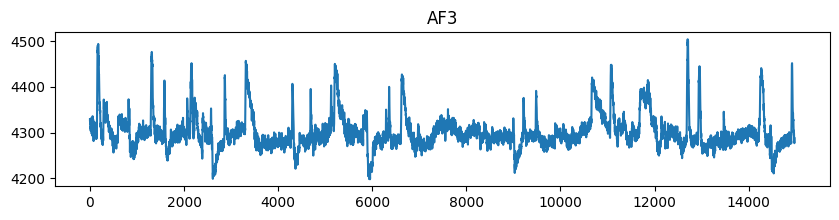

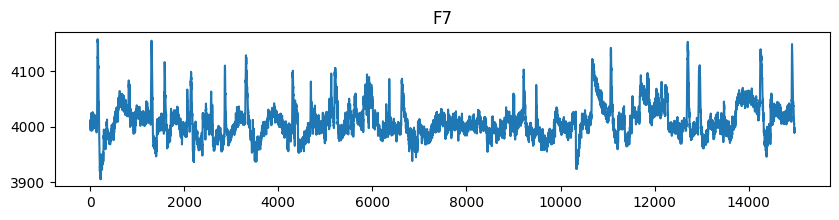

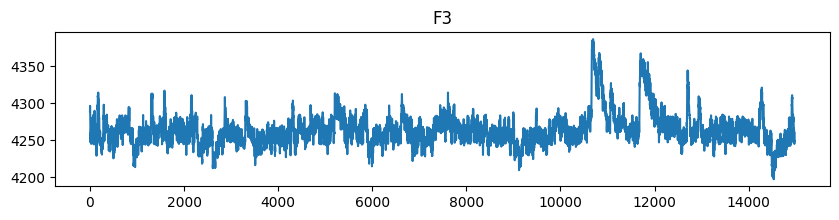

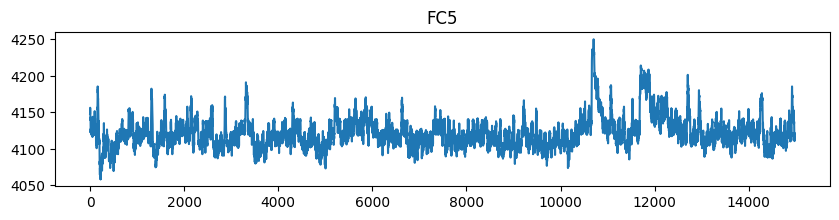

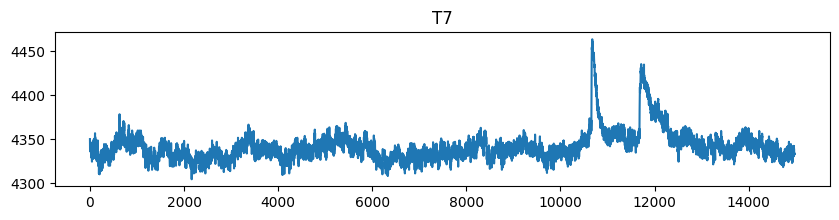

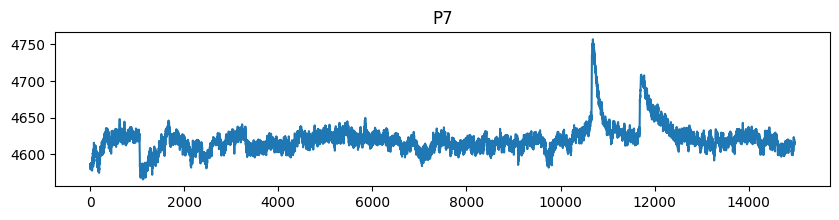

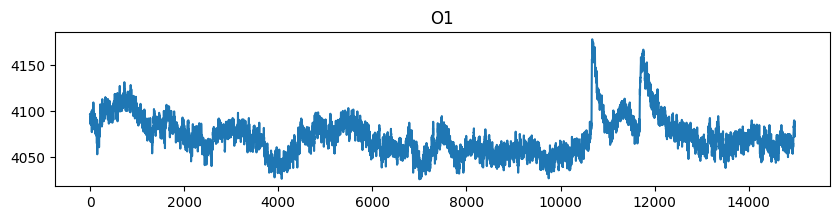

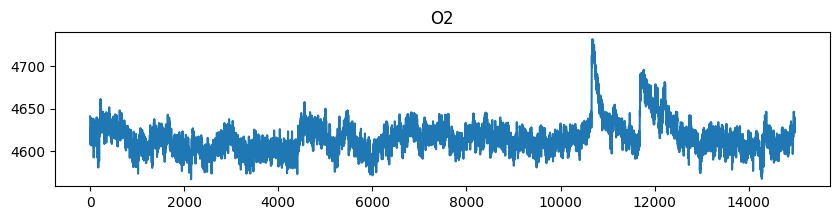

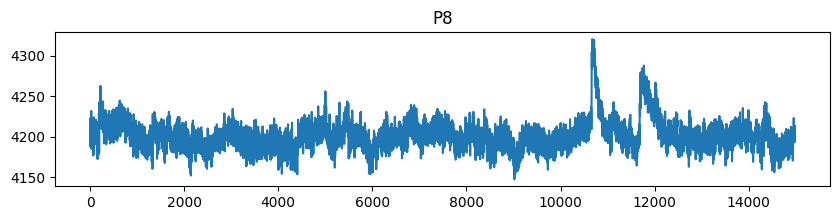

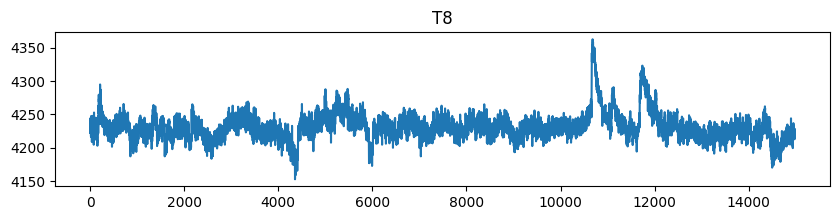

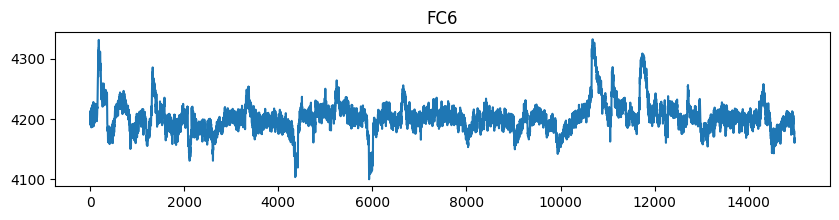

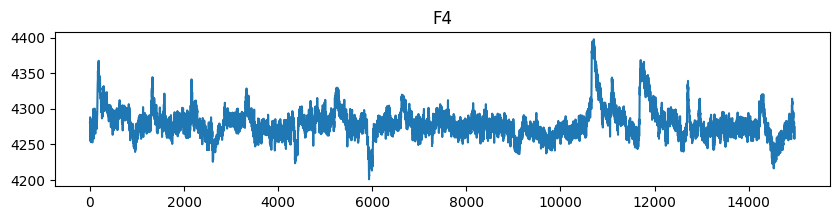

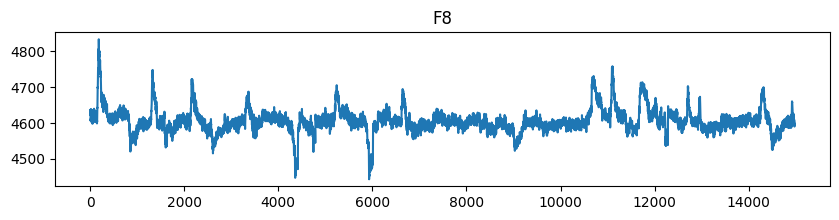

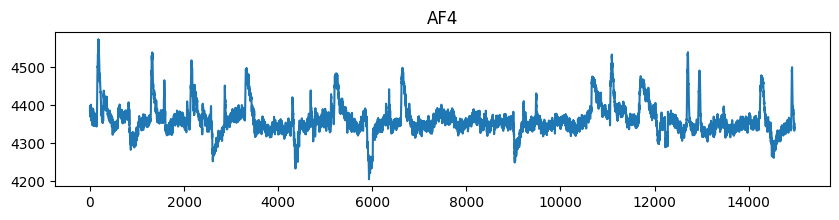

In [15]:
z_score = stats.zscore(data)
abs_z_score = np.abs(z_score)

filter_condition = (abs_z_score < 4).all(axis=1)

filter_data = data[filter_condition]

filter_data = filter_data.reset_index(drop=True)

plot = filter_data.drop(columns="eyeDetection")

for col in plot.columns:
    plot[col].plot(figsize=(10,2), title=col)
    plt.show()

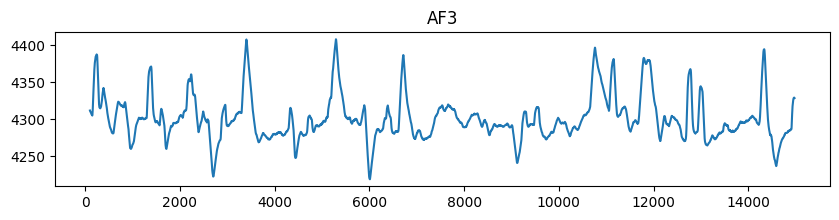

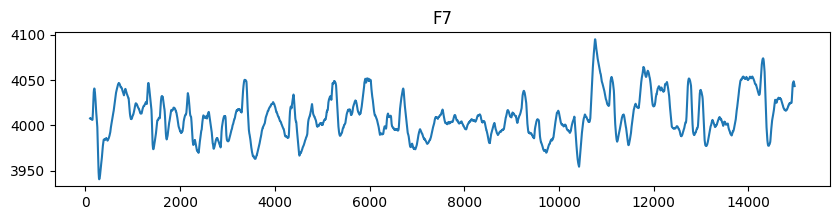

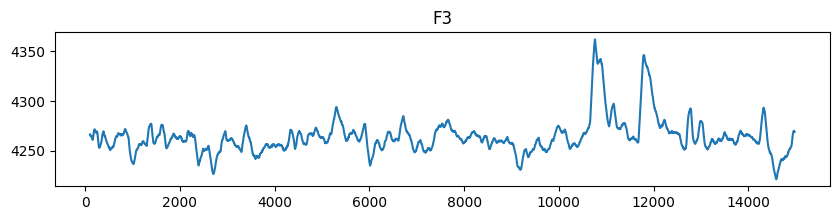

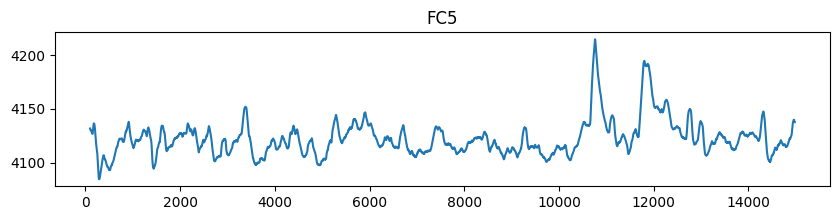

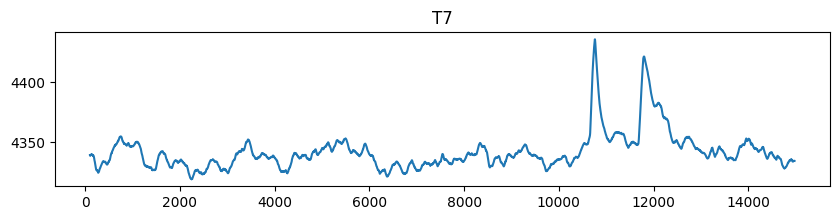

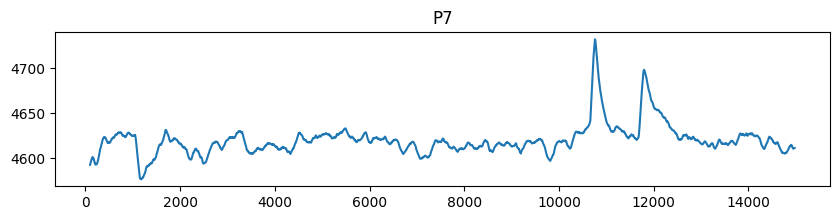

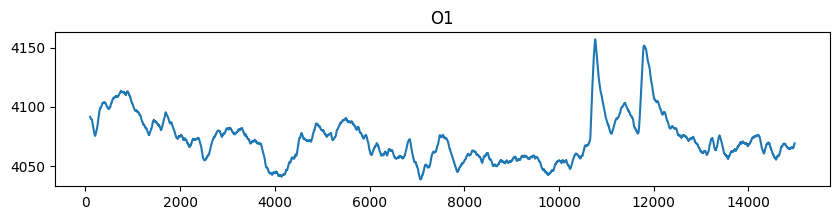

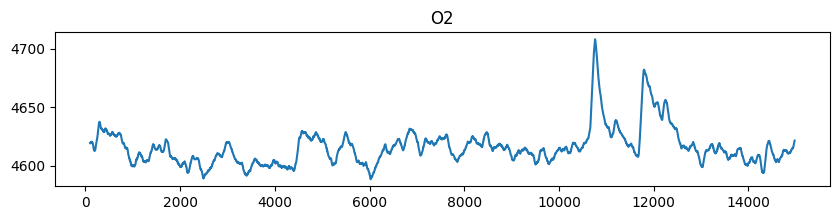

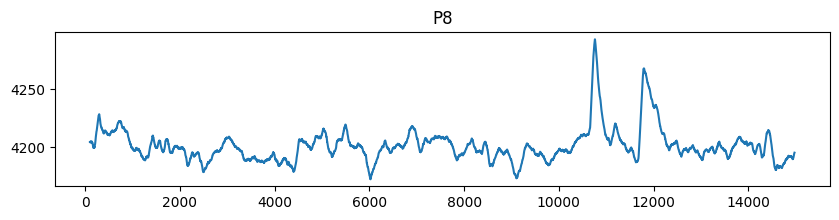

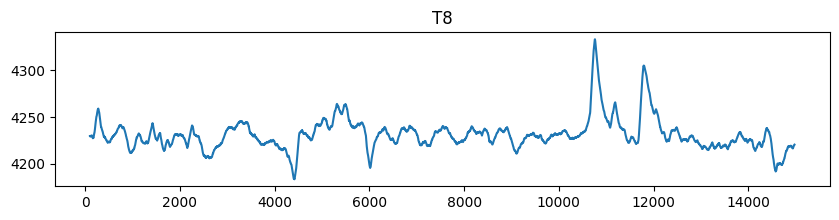

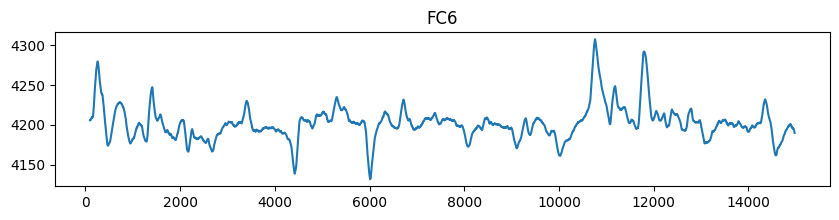

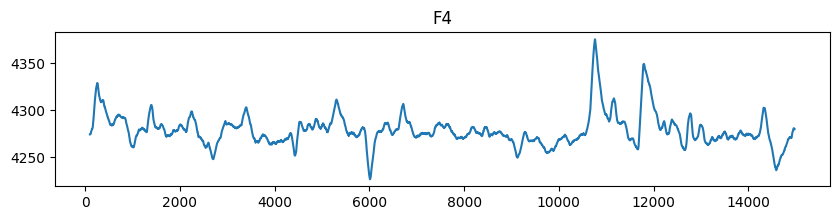

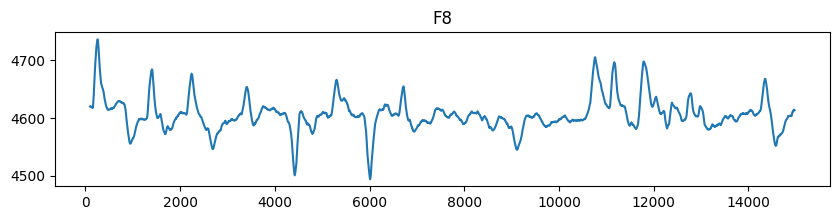

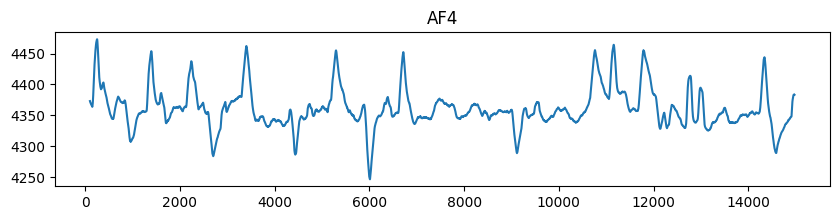

In [16]:
#rolling average (Smooth) plot
for col in plot.columns:
    plot[col].rolling(center=False, window=100).mean().plot(figsize=(10,2), title=col)
    plt.show()    



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='eyeDetection', ylabel='Count'>

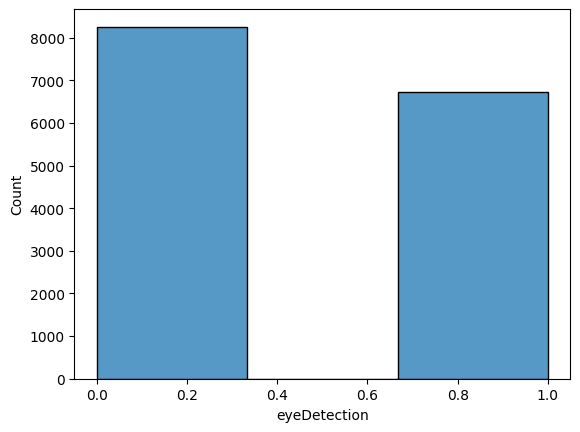

In [17]:
sns.histplot(data=data,x='eyeDetection', bins=3)

In [18]:
for col in data.columns[:-1]:
    data_mean = data[col].mean()
    data_std = data[col].std()
    cutoff = data_std * 4
    lower,upper = data_mean - cutoff, data_mean + cutoff
    data = data[(data[col] >= lower) & (data[col] <= upper)]

data.reset_index(inplace=True, drop=True)

In [19]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14304 entries, 0 to 14303
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AF3           14304 non-null  float64
 1   F7            14304 non-null  float64
 2   F3            14304 non-null  float64
 3   FC5           14304 non-null  float64
 4   T7            14304 non-null  float64
 5   P7            14304 non-null  float64
 6   O1            14304 non-null  float64
 7   O2            14304 non-null  float64
 8   P8            14304 non-null  float64
 9   T8            14304 non-null  float64
 10  FC6           14304 non-null  float64
 11  F4            14304 non-null  float64
 12  F8            14304 non-null  float64
 13  AF4           14304 non-null  float64
 14  eyeDetection  14304 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 1.6 MB


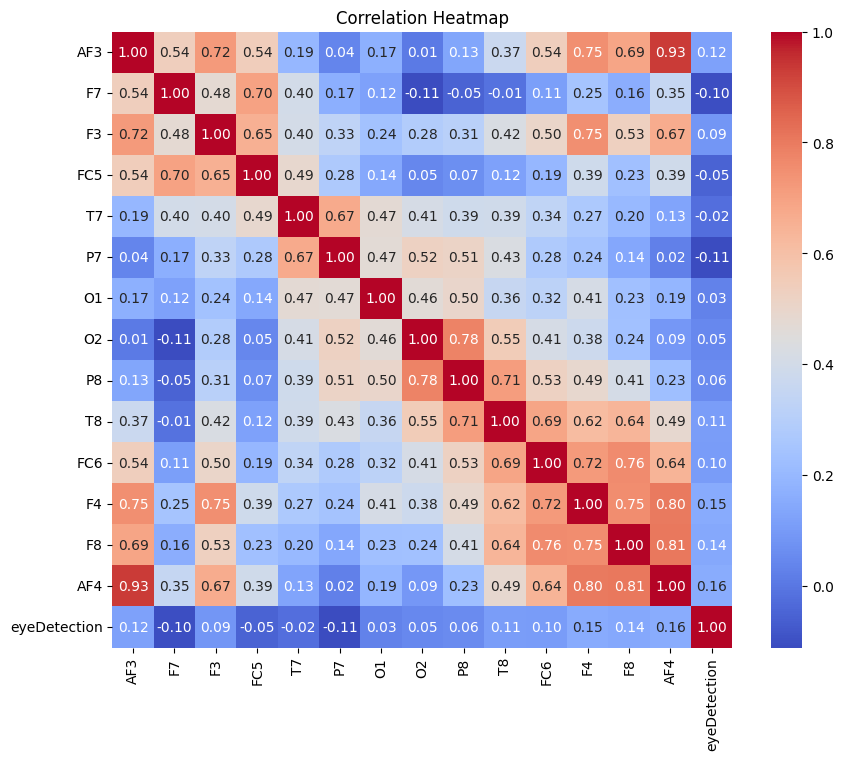

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [21]:
X = data.drop(columns = "eyeDetection")
Y = data["eyeDetection"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, shuffle = True)

scaler = StandardScaler()
X_trainScaled = scaler.fit_transform(X_train)
X_testScaled = scaler.transform(X_test)


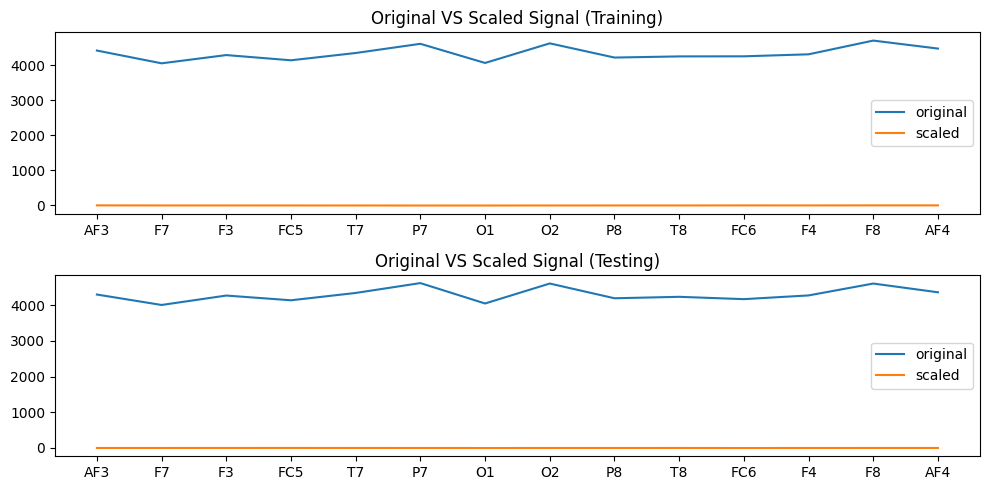

In [22]:
# Plot the original and filtered signals
plt.figure(figsize=(10, 5))

# Plot for X_Train
plt.subplot(2, 1, 1)
plt.plot(X_train.iloc[0,:], label='original')
plt.plot(X_trainScaled[0], label='scaled')  
plt.title('Original VS Scaled Signal (Training)')
plt.legend()

# Plot for X_Test
plt.subplot(2, 1, 2)
plt.plot(X_test.iloc[0,:], label='original')
plt.plot(X_testScaled[0,:], label='scaled')  
plt.title('Original VS Scaled Signal (Testing)')
plt.legend()

plt.tight_layout()

plt.show()

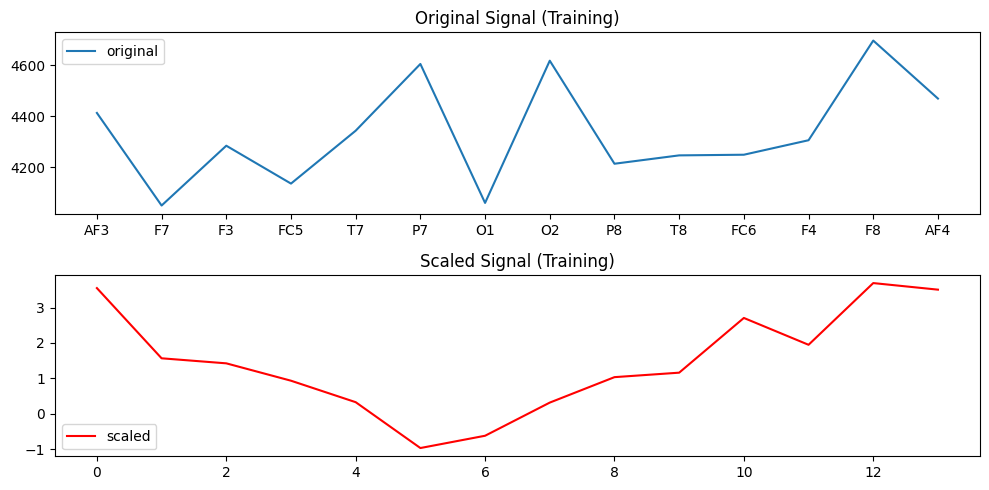

In [23]:
# Plot the original and filtered signals
plt.figure(figsize=(10, 5))

# Plot for X_Train
plt.subplot(2, 1, 1)
plt.plot(X_train.iloc[0,:], label='original')
plt.title('Original Signal (Training)')
plt.legend()

# Plot for X_Train
plt.subplot(2, 1, 2)
plt.plot(X_trainScaled[0], label='scaled', color='red')  
plt.title('Scaled Signal (Training)')
plt.legend()


plt.tight_layout()

plt.show()

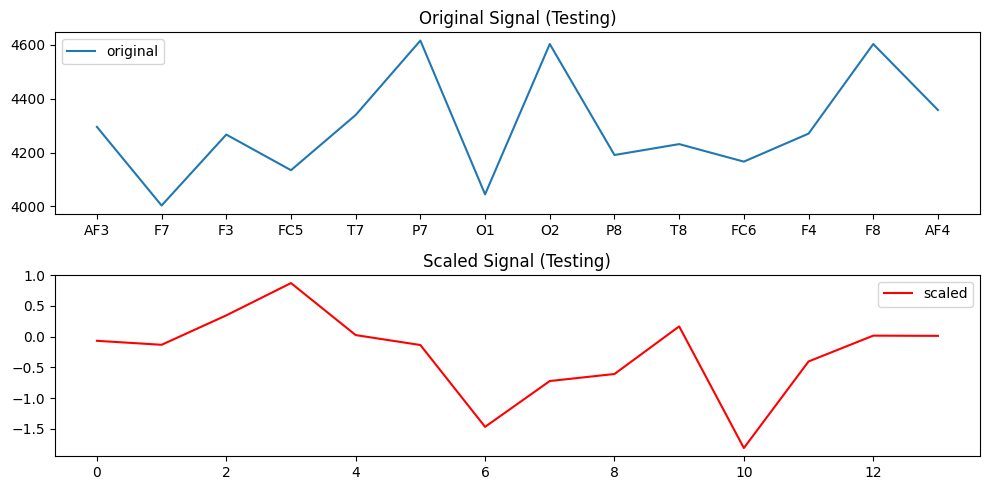

In [24]:
# Plot the original and filtered signals
plt.figure(figsize=(10, 5))

# Plot for X_Train
plt.subplot(2, 1, 1)
plt.plot(X_test.iloc[0,:], label='original')
plt.title('Original Signal (Testing)')
plt.legend()

# Plot for X_Train
plt.subplot(2, 1, 2)
plt.plot(X_testScaled[0], label='scaled', color='red')  
plt.title('Scaled Signal (Testing)')
plt.legend()


plt.tight_layout()

plt.show()

In [25]:
# Define bandpass filter parameters
fs = 200  # Sampling frequency
cutoff_freq = 4.0  # Higher cutoff frequency (Hz)

# Additional EEG preprocessing steps
def highpass_filter(data, cutoff_freq, fs, order=4):
    nyquist = 0.5 * fs
    high = cutoff_freq / nyquist
    b, a = butter(order, high, btype='high')
    y = filtfilt(b, a, data)
    return y
# Apply highpass_filter to EEG signals
X_trainFiltered = highpass_filter(X_trainScaled.T,  cutoff_freq, fs).T
X_testFiltered = highpass_filter(X_testScaled.T,  cutoff_freq, fs).T


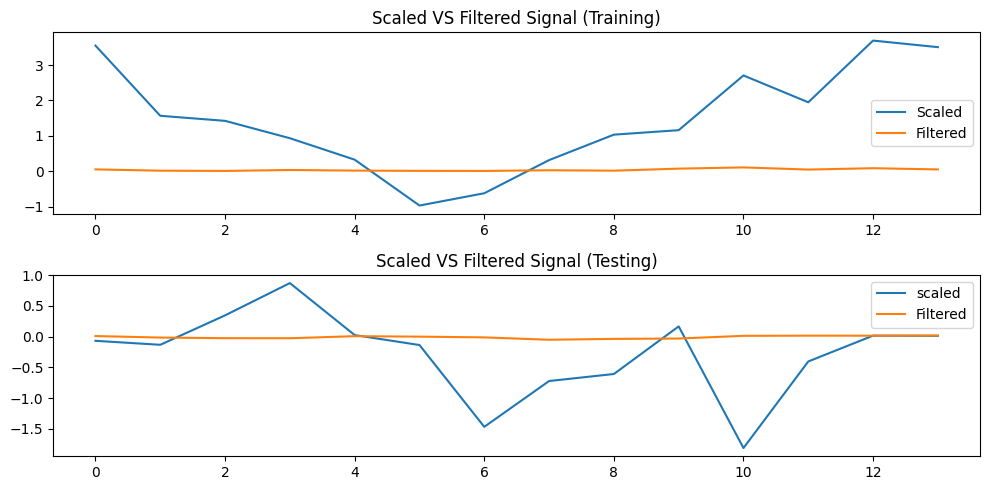

In [26]:
# Plot the original and filtered signals
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(X_trainScaled[0], label='Scaled')
plt.plot(X_trainFiltered[0], label='Filtered')
plt.title('Scaled VS Filtered Signal (Training)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(X_testScaled[0], label='scaled')
plt.plot(X_testFiltered[0], label='Filtered')
plt.title('Scaled VS Filtered Signal (Testing)')
plt.legend()

plt.tight_layout()

plt.show()

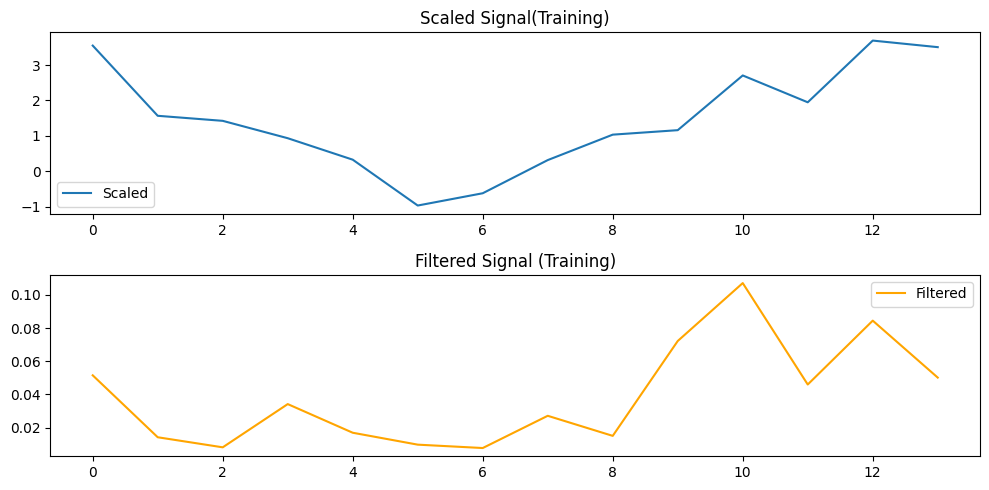

In [27]:
# Plot the original and filtered signals
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(X_trainScaled[0], label='Scaled')
plt.title('Scaled Signal(Training)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(X_trainFiltered[0], label='Filtered', color='orange')
plt.title('Filtered Signal (Training)')
plt.legend()

plt.tight_layout()

plt.show()

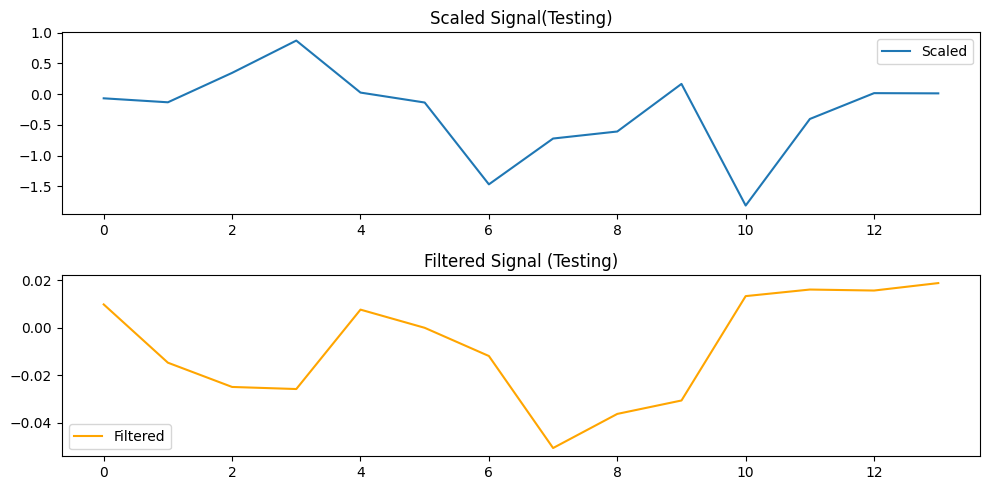

In [28]:
# Plot the original and filtered signals
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(X_testScaled[0], label='Scaled')
plt.title('Scaled Signal(Testing)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(X_testFiltered[0], label='Filtered', color='orange')
plt.title('Filtered Signal (Testing)')
plt.legend()

plt.tight_layout()

plt.show()

In [29]:
#This Filter is Technical I understand the code but I do not know why I have to do that, just that EEG data needs to have this
#applied

def csp_filter(X, y, n_components=13):
    eye_open = np.transpose(X[y==0])
    eye_close = np.transpose(X[y==1])

    cov_0 = np.dot(eye_open, np.transpose(eye_open))/np.trace(np.dot(eye_open,np.transpose(eye_open)))
    cov_1 = np.dot(eye_close,np.transpose(eye_close))/np.trace(np.dot(eye_close,np.transpose(eye_close)))
    
    eigenvalues, eigenvectors = eigh(cov_0, cov_0 + cov_1)

    sorted = np.argsort(eigenvalues)[::-1]
    sortedEigenVectors = eigenvectors[:, sorted]

    # Select top CSP filters
    csp_filters = sortedEigenVectors[:, :n_components]

    return csp_filters
    
    

In [30]:
def apply_csp(X, csp_filters):
    return np.dot(csp_filters.T, X.T).T 


csp_filters = csp_filter(X_trainFiltered, y_train)

X_train_csp = apply_csp(X_trainFiltered, csp_filters)
X_test_csp = apply_csp(X_testFiltered, csp_filters)

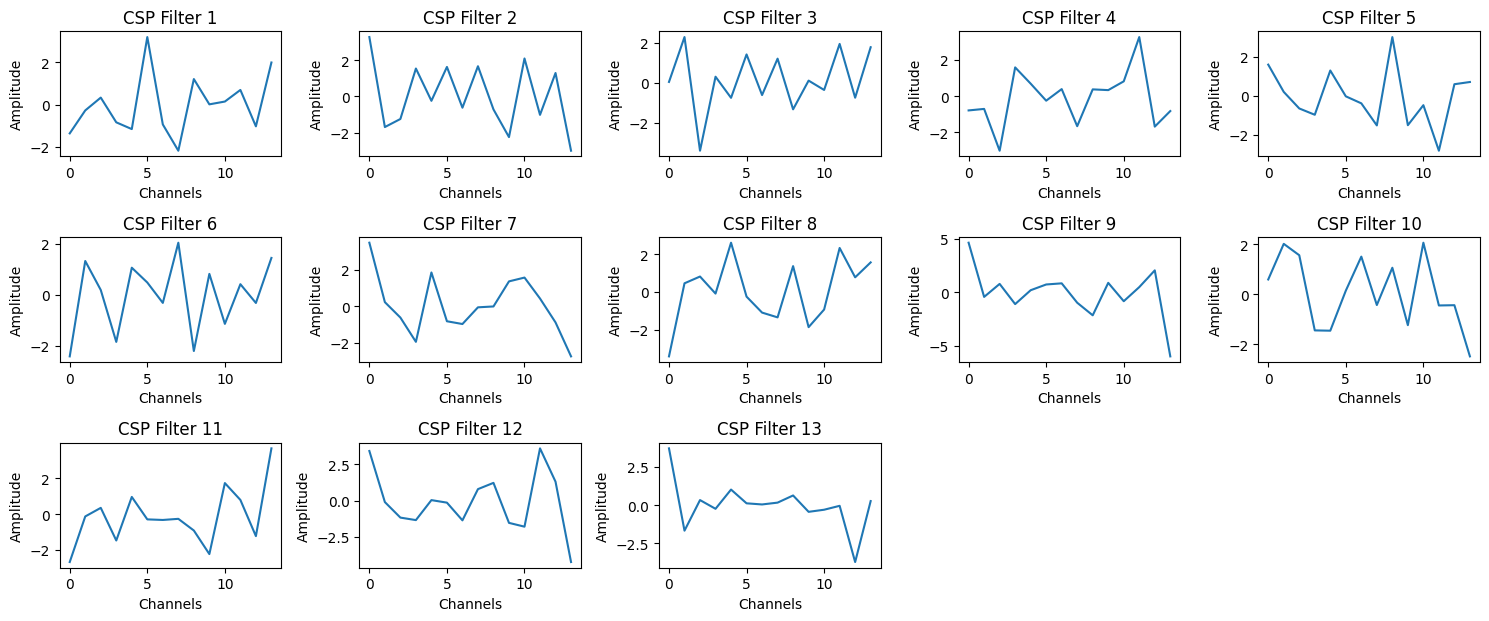

In [31]:
plt.figure(figsize=(15, 10))
for i in range(csp_filters.shape[1]):
    plt.subplot(5, 5, i+1)
    plt.plot(csp_filters[:, i])
    plt.title(f"CSP Filter {i+1}")
    plt.xlabel("Channels")
    plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()


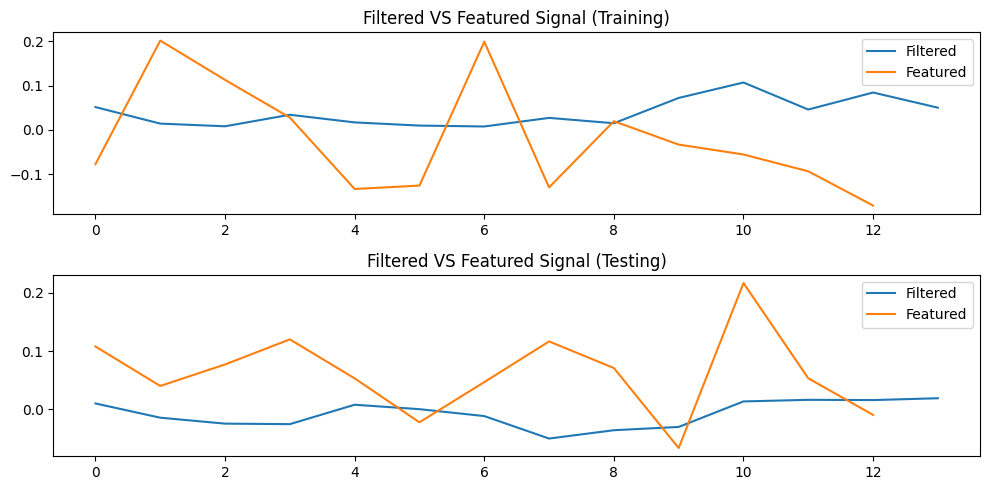

In [32]:
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(X_trainFiltered[0], label='Filtered')
plt.plot(X_train_csp[0], label='Featured')
plt.title('Filtered VS Featured Signal (Training)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(X_testFiltered[0], label='Filtered')
plt.plot(X_test_csp[0], label='Featured')
plt.title('Filtered VS Featured Signal (Testing)')
plt.legend()

plt.tight_layout()

plt.show()

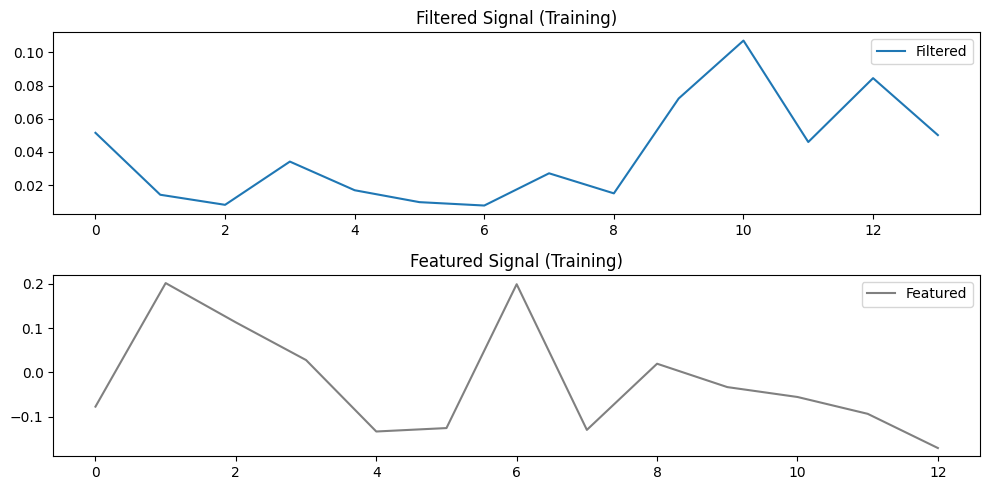

In [33]:
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(X_trainFiltered[0], label='Filtered')
plt.title('Filtered Signal (Training)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(X_train_csp[0], label='Featured', color='grey')
plt.title('Featured Signal (Training)')
plt.legend()

plt.tight_layout()

plt.show()

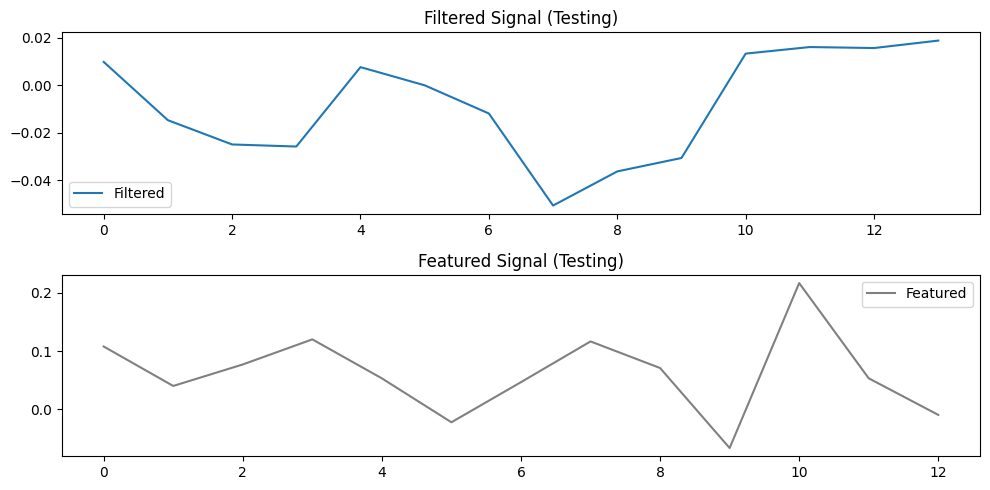

In [38]:
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(X_testFiltered[0], label='Filtered')
plt.title('Filtered Signal (Testing)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(X_test_csp[0], label='Featured', color='grey')
plt.title('Featured Signal (Testing)')
plt.legend()

plt.tight_layout()

plt.show()

In [34]:
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42)

rf_classifier.fit(X, Y)

feature_importances = rf_classifier.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top features contributing the most
print("Top Features Contributing Most:")
print(feature_importance_df.head(10))



Top Features Contributing Most:
   Feature  Importance
6       O1    0.123185
5       P7    0.106283
1       F7    0.090788
12      F8    0.082160
13     AF4    0.077350
0      AF3    0.076094
10     FC6    0.062241
11      F4    0.059911
3      FC5    0.059447
9       T8    0.056399


In [35]:
scores = cross_val_score(rf_classifier, X_train_csp, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy:", scores.mean())

Cross-Validation Accuracy: 0.8899752388284498


In [36]:
# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier( n_estimators=1000, random_state=42)

# Train the Random Forest classifier on the CSP-filtered training data
rf_classifier.fit(X_train_csp, y_train)

# Make predictions on the CSP-filtered training data
y_train_pred = rf_classifier.predict(X_train_csp)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

# Make predictions on the CSP-filtered test data
y_test_pred = rf_classifier.predict(X_test_csp)

# Calculate testing accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", test_accuracy)

print("Classification Report:")
print(classification_report(y_test, y_test_pred))



Training Accuracy: 1.0
Testing Accuracy: 0.9007340090877316
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1518
           1       0.91      0.87      0.89      1343

    accuracy                           0.90      2861
   macro avg       0.90      0.90      0.90      2861
weighted avg       0.90      0.90      0.90      2861

